### Temporal Plot of Raw Data

In [3]:
import os, csv, pickle, gzip, torch, copy
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.transform import Rotation as R

from tqdm import tqdm
from matplotlib import rc #change xtick & ytick size
%matplotlib notebook
%matplotlib inline
from scipy.signal import butter, lfilter, freqz


#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z

def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output


spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

# ver2 file makes vector feature velocity to hold a and b instead of simple subtraction that is useless
file_name = "0919-f18r16ver2"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','length', 'h','v','d']]
# print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])


#=========== group ==================
#depth = (0.9, 1.7, 2.5, 3.3)
#angles = (+-30 azimuth, +-20 elevation)

# 2 5 8
# 1 4 7
# 0 3 6

#cross: 1,3,5,7
#center: 4
#oblique: 0,2,6,8

open gzip


### Plot Velocity For Features

In [86]:
#========= temporal plot functions =========================================================================

# from functools import partial
# from matplotlib.animation import FuncAnimation
# from matplotlib.animation import PillowWriter
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap

# import matplotlib.cm as cm
# from matplotlib.collections import LineCollection


#X for subject= [144, 18, 16]. For the latter half velocity section
#===========================================
#(HMD, lhand, rhand, index) 
#(e1, e2) **e0 was combined eye and not included 
#(efrch, efrc1, efrc2) 
#(vecprod: e1*efrch, e2*efrch, e1*efrc1, e2*efrc2)
#===========================================
def plot_velocity_profile_per_target(ffile, sfile, dffile, PARAMS):
    """
    FUNC: make 16 subject df list on velocity
    FUNC: make 36 combo df list on velocity
    """
    
    # ==== Title & condition flags ===============
    idx_to_plot = int(input("idx to plot"))
    features = ['HMD', 'RHand', 'RIndex', 'LEye', 'REye', 'HFRC', 'EFRC1', 'EFRC2', 'VECPROD']
    feature = features[idx_to_plot]
    flags = ['transform', 'vector', 'vecprod']
    flag = flags[0]
    if(idx_to_plot > 2):
        flag = flags[1]
    elif(idx_to_plot > 6):
        flag = flags[2]
    
    
#     #1. ====================
#     X_sub_comb_list = [] #[16][36][4]
#     for sIdx in range(16):
#         X = ffile[sIdx][0] #[144][F,18,16] X is already trimmed=============
#         pIdx = int(sfile[sIdx][fIdx]) #pointer idx
#         param = PARAMS[sIdx][pIdx]        
        
#         X_list_file = []
#         for fIdx in range(144): 
#             X_f = X[pIdx][:, 9:] #[F,9,16] 
#             X_list_file.append(X_f)
            
#         #======== package to (36 combination, 4 repeat) listlist
#         X_list_comb = [] 
#         for fIdx in range(36): #4repeats for 36 combo = 144 files
#             arr_idx = (cIdx, 36+cIdx, 72+cIdx, 108+cIdx)
#             X_comb = [X_list_file[i] for i in array_idx]
#             X_list_comb.append(X_comb)
            
#         X_sub_comb_list.append(X_list_comb)
            
    # ==== data per target ==============================
    X_comb_sub_list = [] #[36][64, 9, 9, 16] : ONLY VELOCITY
    X_comb_sub_list_pos = [] #[35][64, 9, 9, 16] : ONLY POSITION
    for cIdx in range(36):
        
        X_sub_list = []#64 = 16*4 files
        X_sub_list = []
        for sIdx in range(16):
            # Input for subject & pointer file index
            X_sub = ffile[sIdx][0] #[144][F,J,16]
            arr_pIdx0 = int(sfile[sIdx][cIdx]) 
            arr_pIdx1 = int(sfile[sIdx][cIdx+36]) 
            arr_pIdx2 = int(sfile[sIdx][cIdx+72]) 
            arr_pIdx3 = int(sfile[sIdx][cIdx+108])
            
            # 4 repeat files & velocity feature subset
            X_sub_list.append( X_sub[arr_pIdx0][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx1][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx2][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx3][:, 9:] )
            
        # nest & pad list[tensors]
        X_sub_list = torch.nested.nested_tensor(X_sub_list) # [64, variable F, 16]
        X_sub_list = torch.nested.to_padded_tensor(X_sub_list, 0) # [64, common F, 16]
        X_comb_sub_list.append(X_sub_list)
        

    # ==== common plot ==============================
    plt.figure(figsize=(25,10))
    plt.suptitle("Velocity Profile for " + feature, fontsize=18)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)     
    ax0 = plt.subplot(2, 2, 1)
    leg = [*range(36)]

    # ==== plot 1 ==============================
    ax1 = plt.subplot(2, 2, 1)
    ax1.set_title("Linear Velocity", fontsize=15)
    ax1.set_xlabel('seconds', fontsize=15)
    ax1.set_ylabel('m/s', fontsize=15) 
    # ax1.locator_params(nbins=6, axis='y') #xtick density 
    ax1.set_xlim(0,3)
    # ax1.set_ylim(0,0.35)  
    ax1.locator_params(nbins=5, axis='x') #xtick density

    # ==== plot 2 ==============================
    ax2 = plt.subplot(2, 2, 2)   
    ax2.set_title("Angular Velocity", fontsize=15)
    ax2.set_xlabel('seconds', fontsize=15)
    ax2.set_ylabel('deg/s', fontsize=15)
    ax2.locator_params(nbins=5, axis='x') #xtick density    
    # ax2.locator_params(nbins=6, axis='y') #xtick density        
    ax2.set_xlim(0,3)
    # ax2.set_ylim(0,60) 
    handles = [*str(range(36))]
    ax2.legend(handles)
    handle1=[]
    handle2=[]
    

    
    
    for cIdx in range(36):
        # Color for different configs
        
        #========COLOR PER DISTANCE ===========
        
        #========COLOR PER ANGLE ==============
        
        
        
        # ===== average data & downsample =========================
        X_comb = X_comb_sub_list[cIdx] #[64, F, 9, 16]
        X_comb_avg = torch.mean(X_comb, 0) #[F, 9, 16]
        X_plot = X_comb_avg[:, int(idx_to_plot)]
        frametime = 1/120
        
        # ===== calc lin/rot delta =========================
        if flag == 'transform':
            positions = X_plot[:,(3,7,11)]
            rot = torch.reshape(X_plot[:,(0,1,2, 4,5,6, 8,9,10)], (-1,3,3))
            r = R.from_matrix(rot) #[N,3,3]
        elif flag == 'vector':         
            # https://gist.github.com/aormorningstar/3e5dda91f155d7919ef6256cb057ceee
            # finding a unique rotation is impossible with Kabsch algorithm
            positions = X_plot[:,(8,9,10)] #Trash values
            past_vec = X_plot[:,(0,1,2)] #Trash values
            curr_vec = X_plot[:,(4,5,6)] #Trash values
            rot_matrices = calc_rot_matrices(past_vec, curr_vec)
            r = R.from_matrix(rot_matrices)
            
        r_vec = torch.tensor(R.as_rotvec(r,  degrees=True)) #[N, 3]
        r_delta_angle = torch.linalg.vector_norm(r_vec, dim=1) #[N] #LOSS of DIRECTIONAL INFORMATION
        r_euler = torch.tensor(R.as_euler(r
        
        r_dalta_angle_x = r_vec[:,0]
        r_delta_angle_y = r_vec[:,1]
        r_delta_angle_z = r_vec[:,2]

        # ===== calc lin/rot velocity =========================
        y_linvel = torch.norm(positions, dim=1) / frametime
        y_rotvel = (r_delta_angle)/ frametime    
        
        #=======================================================
        # ===== Apply LPF for eye data with high frequency =====
        #=======================================================
        if idx_to_plot == 3 or idx_to_plot == 4:
            cutoff = 3 #Hz
            fs = 120 #Hz sampling
            order = 6
            y_rotvel = butter_lowpass_filter(y_rotvel, cutoff, fs, order)          
   
        
        # ==== downsample & set x linspace ==========================
        new_frametime = frametime*3 #resolution should be at least 60Hz
        y_linvel = y_linvel[::3]
        y_rotvel = y_rotvel[::3]    
        x = torch.linspace(0, y_linvel.shape[0]*new_frametime, y_linvel.shape[0])
        
        # ===== plot linvel =========================
        line_1, = ax1.plot(x, y_linvel, label=str(cIdx))
        line_2, = ax2.plot(x, y_rotvel, label=str(cIdx))
        handle1.append(line_1)
        handle2.append(line_2)
        
    # ax1.legend(handles=handle1)
    # ax2.legend(handles=handle2)

    
def calc_rot_matrices(a, b):
    """
    https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    matrix R that rotates unit vector a onto unit vector b
    input: v1: (N,3)
    input: v2: (N,3)
    """
    rot_list = []
    for f in range(a.shape[0]):                           
        v1 = a[f]
        v2 = b[f]
        v = np.cross(v1, v2) 
        s = np.linalg.norm(v)
        c = np.dot(v1, v2)
        vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])                           
        mat = np.eye(3) + vx + np.dot(vx,vx)/(1+c)
        rot_list.append(mat)
    r = np.array(rot_list)    
    return r

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

idx to plot 2


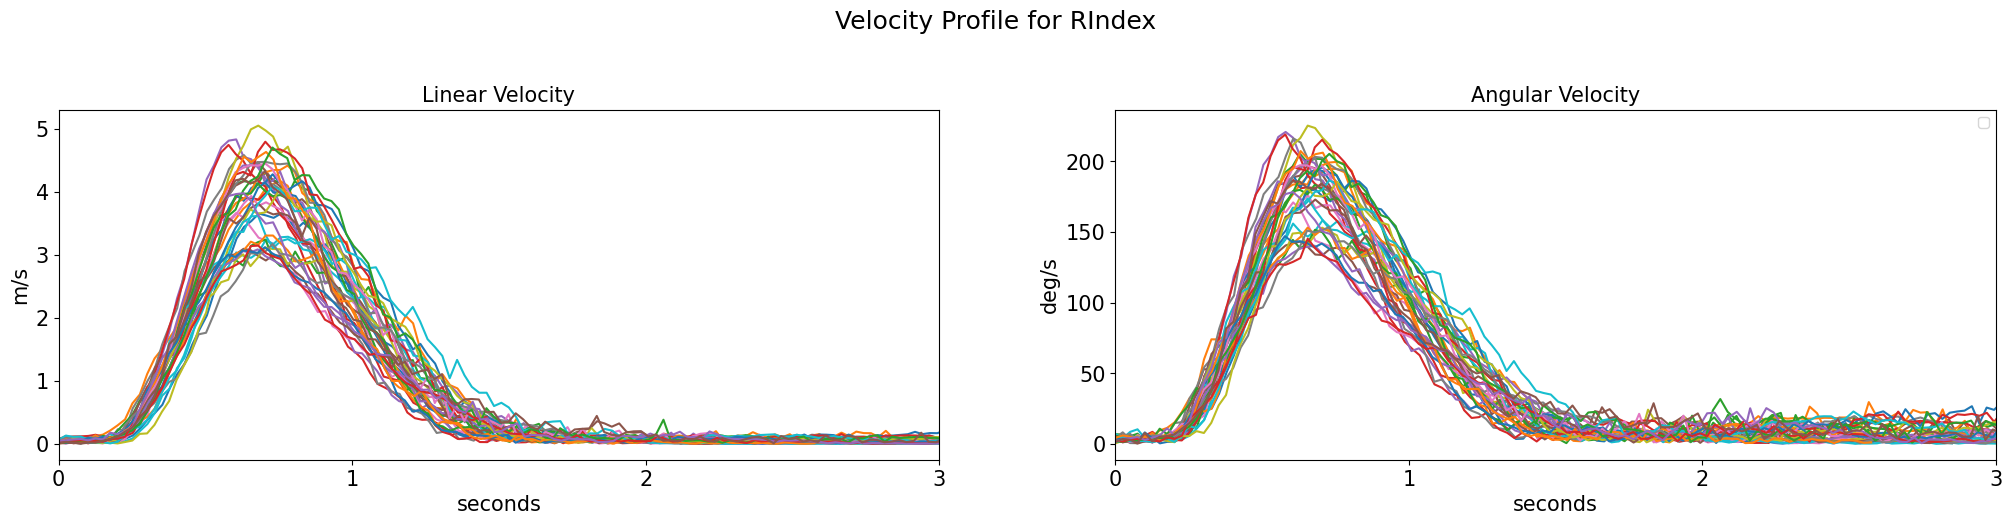

In [87]:
# calc_meta_data(dffile)
plot_velocity_profile_per_target(ffile, sfile, dffile, PARAMS)

### Completion Time Distribution

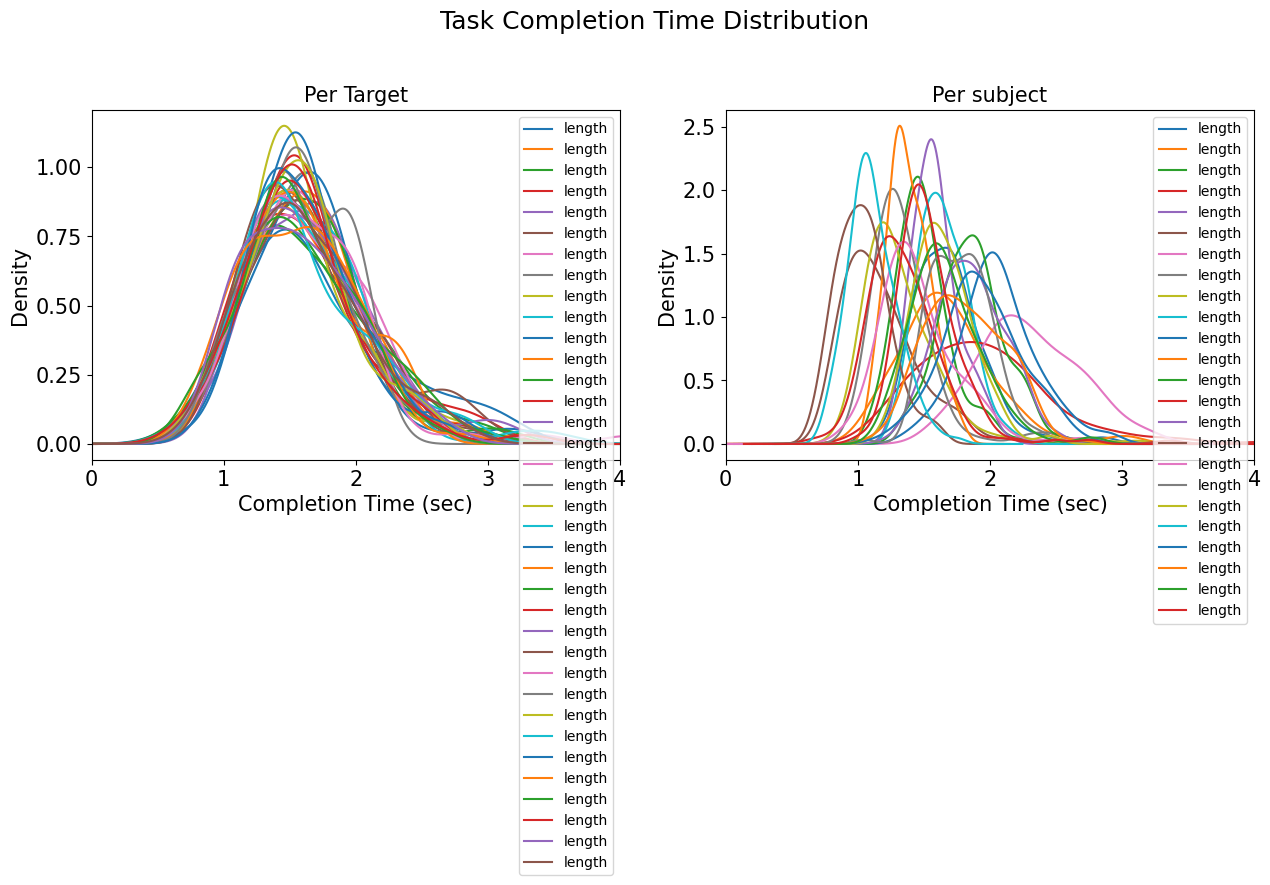

In [70]:
def plot_tasktime_distribution(dffile):
    # https://note.nkmk.me/en/python-pandas-multiple-conditions/#select-rows-by-multiple-conditions
    """
    dffile = pd of ['sub_idx','file_idx','length', 'h','v','d']
    
    1. use sub(0-15)
    2. isolate by 36 combinations
    3. find mean avg / std for length
    """
    
    
    # ==== common plot ==============================
    plt.figure(figsize=(15,10))
    plt.suptitle("Task Completion Time Distribution", fontsize=18)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    
    
    # ===== plot by combination =====================
    ax1 = plt.subplot(2, 2, 1)
    ax1.set_title("Per Target", fontsize=15)
    ax1.set_xlabel('Completion Time (sec)', fontsize=15)
    ax1.set_ylabel('density', fontsize=15)
    ax1.locator_params(nbins=5, axis='x') #xtick density
    ax1.locator_params(nbins=6, axis='y') #xtick density
    ax1.set_xlim(0, 4)
    df = dffile.loc[ dffile['sub_idx']<16]
    df_combination = pd.DataFrame()
    for cIdx in range(36):
        v1, v2, v3, v4 = cIdx, 36+cIdx, 72+cIdx, 108+cIdx
        df_comb = df.loc[ (df['file_idx'] == v1) | (df['file_idx'] ==v2) | (df['file_idx'] == v3) | (df['file_idx'] == v4)]
        df_comb = df_comb.loc[df_comb['length'] > -1].reset_index(drop=True)
        col_name = 'c' + str(cIdx)
        df_comb_length = df_comb['length']/120
        # print(df_comb_length.shape[0], "//", round(df_comb_length.mean(),2), "/", round(df_comb_length.min(),2), "/", round(df_comb_length.max(),2), "/", round(df_comb_length.std(),2))
        ax = df_comb_length.plot.kde()

    
    
    # ===== plot by subject =========================
    ax2 = plt.subplot(2, 2, 2)    
    ax2.set_title("Per subject", fontsize=15)
    ax2.set_xlabel('Completion Time (sec)', fontsize=15)
    ax2.set_ylabel('density', fontsize=15)
    ax2.locator_params(nbins=5, axis='x') #xtick density    
    ax2.locator_params(nbins=6, axis='y') #xtick density
    ax2.set_xlim(0, 4)
    
    df = dffile       
    for sIdx in range(24):
        df_sub = df.loc[ (df['sub_idx'] == sIdx) ]
        df_sub = df_sub.loc[df_sub['length'] > -1].reset_index(drop=True)
        df_sub_length = df_sub['length']/120
        # print(sIdx, "//", round(df_sub_length.mean(),2), "/", round(df_sub_length.min(),2), "/", round(df_sub_length.max(),2), "/", round(df_sub_length.std(),2))            
        ax = df_sub_length.plot.kde()
        
    ax1.legend()
    ax2.legend()
plot_tasktime_distribution(dffile)        

### Profile Per Distance or Angle Combinations

In [ ]:
#========= temporal plot functions =========================================================================

# from functools import partial
# from matplotlib.animation import FuncAnimation
# from matplotlib.animation import PillowWriter
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap

# import matplotlib.cm as cm
# from matplotlib.collections import LineCollection


#X for subject= [144, 18, 16]. For the latter half velocity section
#===========================================
#(HMD, lhand, rhand, index) 
#(e1, e2) **e0 was combined eye and not included 
#(efrch, efrc1, efrc2) 
#(vecprod: e1*efrch, e2*efrch, e1*efrc1, e2*efrc2)
#===========================================
def plot_velocity_profile_per_target(ffile, sfile, dffile, PARAMS):
    """
    FUNC: make 16 subject df list on velocity
    FUNC: make 36 combo df list on velocity
    """
    
    # ==== Title & condition flags ===============
    idx_to_plot = int(input("idx to plot"))
    features = ['HMD', 'RHand', 'RIndex', 'LEye', 'REye', 'HFRC', 'EFRC1', 'EFRC2', 'VECPROD']
    feature = features[idx_to_plot]
    flags = ['transform', 'vector', 'vecprod']
    flag = flags[0]
    if(idx_to_plot > 2):
        flag = flags[1]
    elif(idx_to_plot > 6):
        flag = flags[2]
    
    
#     #1. ====================
#     X_sub_comb_list = [] #[16][36][4]
#     for sIdx in range(16):
#         X = ffile[sIdx][0] #[144][F,18,16] X is already trimmed=============
#         pIdx = int(sfile[sIdx][fIdx]) #pointer idx
#         param = PARAMS[sIdx][pIdx]        
        
#         X_list_file = []
#         for fIdx in range(144): 
#             X_f = X[pIdx][:, 9:] #[F,9,16] 
#             X_list_file.append(X_f)
            
#         #======== package to (36 combination, 4 repeat) listlist
#         X_list_comb = [] 
#         for fIdx in range(36): #4repeats for 36 combo = 144 files
#             arr_idx = (cIdx, 36+cIdx, 72+cIdx, 108+cIdx)
#             X_comb = [X_list_file[i] for i in array_idx]
#             X_list_comb.append(X_comb)
            
#         X_sub_comb_list.append(X_list_comb)
            
    # ==== data per target ==============================
    X_comb_sub_list = [] #[36][64, 9, 9, 16] : ONLY VELOCITY
    X_comb_sub_list_pos = [] #[35][64, 9, 9, 16] : ONLY POSITION
    for cIdx in range(36):
        
        X_sub_list = []#64 = 16*4 files
        X_sub_list = []
        for sIdx in range(16):
            # Input for subject & pointer file index
            X_sub = ffile[sIdx][0] #[144][F,J,16]
            arr_pIdx0 = int(sfile[sIdx][cIdx]) 
            arr_pIdx1 = int(sfile[sIdx][cIdx+36]) 
            arr_pIdx2 = int(sfile[sIdx][cIdx+72]) 
            arr_pIdx3 = int(sfile[sIdx][cIdx+108])
            
            # 4 repeat files & velocity feature subset
            X_sub_list.append( X_sub[arr_pIdx0][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx1][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx2][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx3][:, 9:] )
            
            
            
        
        # nest & pad list[tensors]
        X_sub_list = torch.nested.nested_tensor(X_sub_list) # [64, variable F, 16]
        X_sub_list = torch.nested.to_padded_tensor(X_sub_list, 0) # [64, common F, 16]
        X_comb_sub_list.append(X_sub_list)
        

    # ==== common plot ==============================
    plt.figure(figsize=(25,10))
    plt.suptitle("Velocity Profile for " + feature, fontsize=18)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)     
    ax0 = plt.subplot(2, 2, 1)
    leg = [*range(36)]

    # ==== plot 1 ==============================
    ax1 = plt.subplot(2, 2, 1)
    ax1.set_title("Linear Velocity", fontsize=15)
    ax1.set_xlabel('seconds', fontsize=15)
    ax1.set_ylabel('m/s', fontsize=15) 
    # ax1.locator_params(nbins=6, axis='y') #xtick density 
    ax1.set_xlim(0,3)
    # ax1.set_ylim(0,0.35)  
    ax1.locator_params(nbins=5, axis='x') #xtick density

    # ==== plot 2 ==============================
    ax2 = plt.subplot(2, 2, 2)   
    ax2.set_title("Angular Velocity", fontsize=15)
    ax2.set_xlabel('seconds', fontsize=15)
    ax2.set_ylabel('deg/s', fontsize=15)
    ax2.locator_params(nbins=5, axis='x') #xtick density    
    # ax2.locator_params(nbins=6, axis='y') #xtick density        
    ax2.set_xlim(0,3)
    # ax2.set_ylim(0,60) 
    handles = [*str(range(36))]
    ax2.legend(handles)
    handle1=[]
    handle2=[]
    

    
    
    for cIdx in range(36):
        # Color for different configs
        
        #========COLOR PER DISTANCE ===========
        
        #========COLOR PER ANGLE ==============
        
        
        
        # ===== average data & downsample =========================
        X_comb = X_comb_sub_list[cIdx] #[64, F, 9, 16]
        X_comb_avg = torch.mean(X_comb, 0) #[F, 9, 16]
        X_plot = X_comb_avg[:, int(idx_to_plot)]
        frametime = 1/120
        
        # ===== calc lin/rot delta =========================
        if flag == 'transform':
            positions = X_plot[:,(3,7,11)]
            rot = torch.reshape(X_plot[:,(0,1,2, 4,5,6, 8,9,10)], (-1,3,3))
            r = R.from_matrix(rot) #[N,3,3]
        elif flag == 'vector':         
            # https://gist.github.com/aormorningstar/3e5dda91f155d7919ef6256cb057ceee
            # finding a unique rotation is impossible with Kabsch algorithm
            positions = X_plot[:,(8,9,10)] #Trash values
            past_vec = X_plot[:,(0,1,2)] #Trash values
            curr_vec = X_plot[:,(4,5,6)] #Trash values
            rot_matrices = calc_rot_matrices(past_vec, curr_vec)
            r = R.from_matrix(rot_matrices)
            
        r_vec = torch.tensor(R.as_rotvec(r,  degrees=True)) #[N, 3]
        r_delta_angle = torch.linalg.vector_norm(r_vec, dim=1) #[N] #LOSS of DIRECTIONAL INFORMATION
        r_dalta_angle_x = r_vec[:,0]
        r_delta_angle_y = r_vec[:,1]
        r_delta_angle_z = r_vec[:,2]

        # ===== calc lin/rot velocity =========================
        y_linvel = torch.norm(positions, dim=1) / frametime
        y_rotvel = (r_delta_angle)/ frametime    
        
        #=======================================================
        # ===== Apply LPF for eye data with high frequency =====
        #=======================================================
        if idx_to_plot == 3 or idx_to_plot == 4:
            cutoff = 3 #Hz
            fs = 120 #Hz sampling
            order = 6
            y_rotvel = butter_lowpass_filter(y_rotvel, cutoff, fs, order)          
   
        
        # ==== downsample & set x linspace ==========================
        new_frametime = frametime*3 #resolution should be at least 60Hz
        y_linvel = y_linvel[::3]
        y_rotvel = y_rotvel[::3]    
        x = torch.linspace(0, y_linvel.shape[0]*new_frametime, y_linvel.shape[0])
        
        # ===== plot linvel =========================
        line_1, = ax1.plot(x, y_linvel, label=str(cIdx))
        line_2, = ax2.plot(x, y_rotvel, label=str(cIdx))
        handle1.append(line_1)
        handle2.append(line_2)
        
    # ax1.legend(handles=handle1)
    # ax2.legend(handles=handle2)

    
def calc_rot_matrices(a, b):
    """
    https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    matrix R that rotates unit vector a onto unit vector b
    input: v1: (N,3)
    input: v2: (N,3)
    """
    rot_list = []
    for f in range(a.shape[0]):                           
        v1 = a[f]
        v2 = b[f]
        v = np.cross(v1, v2) 
        s = np.linalg.norm(v)
        c = np.dot(v1, v2)
        vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])                           
        mat = np.eye(3) + vx + np.dot(vx,vx)/(1+c)
        rot_list.append(mat)
    r = np.array(rot_list)    
    return r

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y